In [1]:
#!pip install -e ../Maccabee > /dev/null

In [1]:
from maccabee.data_analysis import calculate_data_axis_metrics, gather_axis_metrics_for_given_params
from maccabee.constants import Constants
import maccabee.data_sources as data_sources
from maccabee.parameters import build_default_parameters

from maccabee.data_generation import SampledDataGeneratingProcess, data_generating_method

# benchmarks
from maccabee.benchmarking import benchmark_model_using_concrete_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.benchmarking import benchmark_model_using_sampled_dgp_grid

# genmatch
from maccabee.examples.genmatch import GenmatchDataGeneratingProcess, build_genmatch_datasource, GENMATCH_SPECS
from maccabee.examples.genmatch import LogisticPropensityMatchingCausalModel

In [2]:
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
BASE_GENMATCH_DGP_PARAMS = {
  "OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY": { 
        "LINEAR": 0.7,
        "POLY_QUAD": 0,
        "POLY_CUBIC": 0,
        "STEP_JUMP": 0,
        "STEP_KINK": 0,
        "INTERACTION_TWO_WAY": 0,
        "INTERACTION_THREE_WAY": 0,
  },
  "TREATMENT_EFFECT_HETEROGENEITY": 0,
  "ACTUAL_CONFOUNDER_ALIGNMENT": 0,
  "MIN_PROPENSITY_SCORE": 0.1,
  "MAX_PROPENSITY_SCORE": 0.9,
  "OUTCOME_NOISE_TAIL_THICKNESS": 1000,
  "SUBFUNCTION_CONSTANT_TAIL_THICKNESS": 1000,
  "TREATMENT_EFFECT_TAIL_THICKNESS": 1000
}

A_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
A_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}
  
C_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
C_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.0,
    "INTERACTION_THREE_WAY": 0,
}

G_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
G_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.3,
    "POLY_CUBIC": 0,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.11,
    "INTERACTION_THREE_WAY": 0,
}

X_param_overrides = BASE_GENMATCH_DGP_PARAMS.copy()
X_param_overrides["TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY"] = { 
    "LINEAR": 0.7,
    "POLY_QUAD": 0.99,
    "POLY_CUBIC": 0.99,
    "STEP_JUMP": 0,
    "STEP_KINK": 0,
    "INTERACTION_TWO_WAY": 0.99,
    "INTERACTION_THREE_WAY": 0,
}

In [4]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_true, Y)"
    ],
    Constants.AxisNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)",
        "Lin r2(X_true, Treat Logit)",
        "Log r2(X_obs, T)"
    ],
    Constants.AxisNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.AxisNames.BALANCE: [
        "Wass dist X_true: T=1<->T=0",
    ],
    Constants.AxisNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.AxisNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

## Run MC Benchmarks

In [61]:
%%time

CONCRETE_IN_ANALYSIS_MODE = True

# Concrete Genmatch Benchmark
dgp = GenmatchDataGeneratingProcess(
    *GENMATCH_SPECS["G"],
    n_observations=1000,
    data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE)

concrete_perf_agg, concrete_perf_raw, concrete_data_agg, concrete_data_raw = \
    benchmark_model_using_concrete_dgp(
        dgp=dgp,
        model_class=LogisticPropensityMatchingCausalModel,
        estimand=Constants.Model.ATE_ESTIMAND,
        num_runs=20,
        num_samples_from_dgp=112,
        data_analysis_mode=CONCRETE_IN_ANALYSIS_MODE,
        data_metrics_spec=DATA_METRICS_SPEC,
        n_jobs=7)

CPU times: user 16.8 s, sys: 5.49 s, total: 22.3 s
Wall time: 2min 27s


In [109]:
%%time

SAMPLED_IN_ANALYSIS_MODE = True

# Sampled Genmatch Benchmark
class ModifiedNoiseSampledDataGeneratingProcess(SampledDataGeneratingProcess):
    @data_generating_method(Constants.OUTCOME_NOISE_NAME, [])
    def _generate_outcome_noise_samples(self, input_vars):
        return 0
    
dgp_params = build_default_parameters()
dgp_params.set_parameters(G_param_overrides)

sampled_perf_agg, sampled_perf_raw, sampled_data_agg, sampled_data_raw = \
    benchmark_model_using_sampled_dgp(
        dgp_params, build_genmatch_datasource(),
        dgp_kwargs={"data_analysis_mode": SAMPLED_IN_ANALYSIS_MODE},
        dgp_class=ModifiedNoiseSampledDataGeneratingProcess,
        model_class=LogisticPropensityMatchingCausalModel,
        estimand=Constants.Model.ATE_ESTIMAND,
        num_dgp_samples=15,
        num_sampling_runs_per_dgp=1,
        num_samples_from_dgp=35,
        data_analysis_mode=SAMPLED_IN_ANALYSIS_MODE,
        data_metrics_spec=DATA_METRICS_SPEC,
        n_jobs=7)

CPU times: user 5.25 s, sys: 2.72 s, total: 7.97 s
Wall time: 2min 2s


## Data Metric Comparison

In [110]:
for axes, metrics in DATA_METRICS_SPEC.items():
    print(axes)
    for metric in metrics:
        print("\t", metric)
        
        key = f"{axes} {metric}"
        print("\t\tConcrete:", np.round(concrete_data_agg[key], 3))
        print("\t\tSampled:", np.round(sampled_data_agg[key], 3))

OUTCOME_NONLINEARITY
	 Lin r2(X_obs, Y)
		Concrete: 0.971
		Sampled: 0.857
	 Lin r2(X_true, Y)
		Concrete: 0.973
		Sampled: 0.861
TREATMENT_NONLINEARITY
	 Lin r2(X_obs, Treat Logit)
		Concrete: 0.787
		Sampled: 0.755
	 Lin r2(X_true, Treat Logit)
		Concrete: 1.0
		Sampled: 1.0
	 Log r2(X_obs, T)
		Concrete: 0.726
		Sampled: 0.623
PERCENT_TREATED
	 Percent(T==1)
		Concrete: 44.894
		Sampled: 50.103
BALANCE
	 Wass dist X_true: T=1<->T=0
		Concrete: 0.053
		Sampled: 0.055
ALIGNMENT
	 Lin r2(Y, Treat Logit)
		Concrete: 0.031
		Sampled: 0.101
	 Lin r2(Y0, Treat Logit)
		Concrete: 0.006
		Sampled: 0.095
TE_HETEROGENEITY
	 std(TE)/std(Y)
		Concrete: 0.0
		Sampled: 0.0


In [111]:
for name, vals in sampled_data_raw.items():
    if name.startswith("TREATMENT_NONLINEARITY"):
        print(name, vals)

TREATMENT_NONLINEARITY Log r2(X_obs, T) [0.62, 0.612, 0.632, 0.582, 0.605, 0.647, 0.643, 0.603, 0.662, 0.679, 0.589, 0.666, 0.612, 0.586, 0.614]
TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit) [0.753, 0.754, 0.921, 0.632, 0.644, 0.904, 0.946, 0.628, 0.937, 0.99, 0.459, 0.953, 0.885, 0.458, 0.459]
TREATMENT_NONLINEARITY Lin r2(X_true, Treat Logit) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Performance Comparison

Notes

At config A, 20-50 matches across runs. Wide distro. Should investigate the stability of the concrete distro when n=1000.

At config G, 20-50 has much lower bias in the sampled benchmark. The concrete function appears to be a worst case scenario given that very similar functions experience much lower typical bias. The distribution is right tailed and so it is possible that the concrete func chosen is just an (un)lucky sample from right tail.

I will test this by permuting the variable order in the exact same functional form.

### Concrete Performance

In [112]:
concrete_perf_agg

{'absolute mean bias %': 13.033,
 'absolute mean bias % (std)': 2.044,
 'root mean squared error': 0.104,
 'root mean squared error (std)': 0.007}

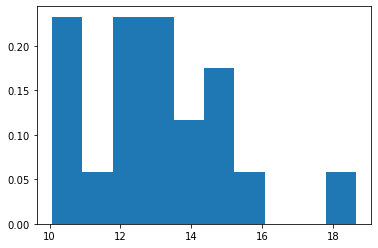

In [113]:
plt.hist(concrete_perf_raw["absolute mean bias %"], density=True)
plt.show()

### Sampled Performance

In [114]:
sampled_perf_agg

{'absolute mean bias %': 4.126,
 'absolute mean bias % (std)': 8.174,
 'root mean squared error': 0.057,
 'root mean squared error (std)': 0.011}

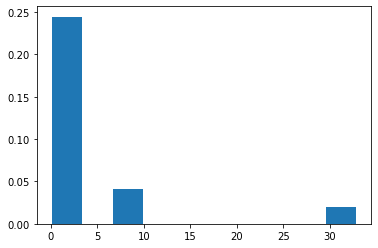

In [115]:
plt.hist(sampled_perf_raw["absolute mean bias %"], density=True)
plt.show()

### Exploratory Analysis

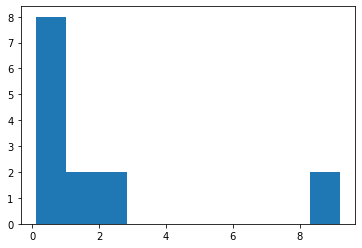

2.0772857142857144

In [119]:
data = np.array(sampled_perf_raw["absolute mean bias %"])
clean_data = data[data < 20]
plt.hist(clean_data)
plt.show()
np.mean(clean_data)

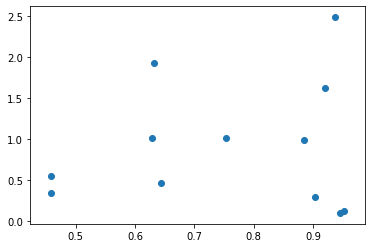

In [120]:
plt.scatter(
    np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
    np.array(sampled_perf_raw["absolute mean bias %"])[data < 8])

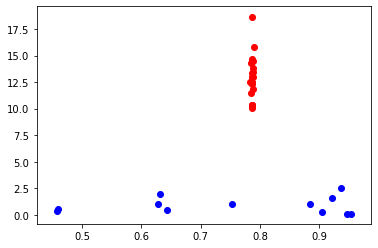

In [118]:
plt.scatter(
    np.array(sampled_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"])[data < 8],
    np.array(sampled_perf_raw["absolute mean bias %"])[data < 8],
    c="b")

plt.scatter(
    np.array(concrete_data_raw["TREATMENT_NONLINEARITY Lin r2(X_obs, Treat Logit)"]),
    np.array(concrete_perf_raw["absolute mean bias %"]),
    c="r")